In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
pd.set_option('display.max_columns', 1000)

import importlib
import warnings
import sys
import time

from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space()

warnings.filterwarnings('ignore')
#if '/project_data/data_asset' not in sys.path:
#    sys.path.insert(0, '/project_data/data_asset')
    
from data_prep import *
from model_build import *
from model_deploy import *


In [2]:
# data prep input variables
train_or_score = 'train'
effective_date_earliest='2016-01-01'
effective_date_latest='2018-09-30'
effective_date='2018-09-30'
columns_required=['CUSTOMER_CUSTOMER_ID', 'CUSTOMER_SUMMARY_END_DATE', 'CUSTOMER_SUMMARY_START_DATE',
                  'CUSTOMER_STATUS', 'CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT', 'CUSTOMER_EFFECTIVE_DATE',
                  'CUSTOMER_RELATIONSHIP_START_DATE']
feature_attributes=['CUSTOMER_AGE_RANGE', 'CUSTOMER_GENDER', 'CUSTOMER_EDUCATION_LEVEL',
                    'CUSTOMER_URBAN_CODE', 'CUSTOMER_MARKET_GROUP', 'CUSTOMER_EMPLOYMENT_STATUS',
                    'CUSTOMER_MARITAL_STATUS', 'CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS', 
                    'CUSTOMER_NUMBER_OF_DEPENDENT_ADULTS', 'CUSTOMER_NUMBER_OF_DEPENDENT_CHILDREN', 
                    'CUSTOMER_ANNUAL_INCOME', 'CUSTOMER_SUMMARY_NUMBER_OF_ACCOUNTS', 
                    'CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT', 'CUSTOMER_SUMMARY_AVERAGE_SENTIMENT_SCORE',
                    'CUSTOMER_INTERNET_BANKING_INDICATOR', 'CUSTOMER_FAMILY_SIZE',
                    'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_HIGH', 'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_LOW',
                    'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_MODERATE', 'NUM_ACCOUNTS_WITH_RISK_TOLERANCE_VERY_LOW',
                    'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_GROWTH', 'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_INCOME',
                    'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_PLANNING', 'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURE_GROWTH',
                    'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURITY']
derive_column_list=["CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS", "CUSTOMER_SUMMARY_FINANCIAL_ASSETS",
                    "CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_MARKET_CHANGE", "CUSTOMER_SUMMARY_NUMBER_OF_TRANSACTIONS",
                    "CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT", "CUSTOMER_SUMMARY_NON_FINANCIAL_ASSETS",
                    "CUSTOMER_SUMMARY_NUMBER_OF_MOBILE_LOGINS", "CUSTOMER_SUMMARY_NUMBER_OF_LOGINS"]
granularity_key="CUSTOMER_CUSTOMER_ID"
target_attribute='TARGET'
status_attribute='CUSTOMER_STATUS'
funds_attribute='CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT'
date_customer_joined='CUSTOMER_RELATIONSHIP_START_DATE'
customer_end_date='CUSTOMER_SUMMARY_END_DATE'
customer_start_date='CUSTOMER_SUMMARY_START_DATE'
period_attribute='CUSTOMER_TENURE'
status_flag_attrition='Inactive'
AUM_reduction_threshold=0.75
forecast_horizon=6
observation_window=6
sum_list=["CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS", "CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_MARKET_CHANGE",
          "CUSTOMER_SUMMARY_NUMBER_OF_TRANSACTIONS"]
cat_threshold=10

In [3]:
customer_history_file = wslib.mount.get_data_path('customer_history.csv')

df_raw = pd.read_csv(customer_history_file,
                     parse_dates=['CUSTOMER_RELATIONSHIP_START_DATE', 'CUSTOMER_SUMMARY_END_DATE',
                                  'CUSTOMER_SUMMARY_START_DATE'], 
                     infer_datetime_format=True)

## 1. Data Prep

In [4]:
data_prep = AttritionPrep(train_or_score, effective_date_earliest, effective_date_latest, effective_date,
                      columns_required, feature_attributes, derive_column_list, granularity_key,
                      target_attribute, status_attribute, funds_attribute, date_customer_joined, 
                      customer_end_date, customer_start_date, period_attribute, status_flag_attrition,
                      AUM_reduction_threshold, forecast_horizon, observation_window, sum_list,
                      cat_threshold)

df_prepped = data_prep.prep_data(df_raw, 'train')

to_drop_more = ['CUSTOMER_TENURE', 'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_PLANNING',
                'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURITY']
df_prepped = df_prepped.drop(to_drop_more, axis=1)

df_prepped.head()

Dataframe shape: (19251, 31)
Count of customers: 1000
162 customers attrited
Columns available for deriving features: ['CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS', 'CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT']
Prepped data for 162 customers
Finished prepping for attrited customers
Prepped data for 561 customers
Finished prepping for non-attrited customers


,CUSTOMER_ANNUAL_INCOME,NUM_ACCOUNTS_WITH_RISK_TOLERANCE_LOW,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS,CUSTOMER_FAMILY_SIZE,CUSTOMER_INTERNET_BANKING_INDICATOR,CUSTOMER_NUMBER_OF_DEPENDENT_CHILDREN,NUM_ACCOUNTS_WITH_RISK_TOLERANCE_VERY_LOW,CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT,CUSTOMER_SUMMARY_AVERAGE_SENTIMENT_SCORE,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_INCOME,NUM_ACCOUNTS_WITH_RISK_TOLERANCE_MODERATE,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_GROWTH,NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURE_GROWTH,CUSTOMER_SUMMARY_NUMBER_OF_ACCOUNTS,NUM_ACCOUNTS_WITH_RISK_TOLERANCE_HIGH,TARGET,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_mean,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_std,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_min,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_max,CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT_mean,CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT_min,CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT_max,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_std_norm,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_current_vs_mean,CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_sum,CUSTOMER_EDUCATION_LEVEL_High School,CUSTOMER_EDUCATION_LEVEL_PhD,CUSTOMER_EDUCATION_LEVEL_Professional,CUSTOMER_EDUCATION_LEVEL_University,CUSTOMER_MARITAL_STATUS_Married,CUSTOMER_MARITAL_STATUS_Single,CUSTOMER_URBAN_CODE_Rural,CUSTOMER_URBAN_CODE_Urban,CUSTOMER_GENDER_Male,CUSTOMER_MARKET_GROUP_Gifting,CUSTOMER_MARKET_GROUP_Spending,CUSTOMER_MARKET_GROUP_Starting,CUSTOMER_AGE_RANGE_30 to 40,CUSTOMER_AGE_RANGE_40 to 55,CUSTOMER_AGE_RANGE_55 to 65,CUSTOMER_AGE_RANGE_65 and over,CUSTOMER_EMPLOYMENT_STATUS_Homemaker,CUSTOMER_EMPLOYMENT_STATUS_Retired,CUSTOMER_EMPLOYMENT_STATUS_Selfemployed,CUSTOMER_EMPLOYMENT_STATUS_Unemployed
0,655000.0,0.0,1417.080532,2,0,0,0.0,750000.0,1,0.0,0.0,0.0,0.0,2,0.0,1,1205.895888,682.349564,177.367675,2066.858831,750000.0,750000.0,750000.0,0.565845,1.175127,7235.375326,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0
1,580000.0,0.0,766.447177,4,0,2,0.0,150000.0,0,0.0,0.0,0.0,0.0,3,0.0,1,1083.573374,460.619376,322.448390,1586.252154,150000.0,150000.0,150000.0,0.425093,0.707333,6501.440244,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,135000.0,0.0,1126.965752,2,0,0,0.0,180000.0,0,0.0,0.0,0.0,0.0,3,0.0,1,1303.866785,323.284549,995.936016,1758.018660,180000.0,180000.0,180000.0,0.247943,0.864326,7823.200712,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0
3,590000.0,0.0,1172.303938,2,1,1,0.0,1250000.0,0,0.0,0.0,0.0,0.0,2,0.0,1,1291.962891,460.112704,660.974400,1895.694947,1250000.0,1250000.0,1250000.0,0.356135,0.907382,7751.777344,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,480000.0,0.0,2235.962616,2,1,0,0.0,1250000.0,2,0.0,0.0,0.0,0.0,2,0.0,1,1793.042669,733.219060,510.145715,2559.979319,1250000.0,1250000.0,1250000.0,0.408924,1.247021,10758.256017,0,0,1,0,1,0,0,1,1,1,0,0,0,0,0,1,0,0,1,0


In [5]:
from sklearn.model_selection import train_test_split

X_inputs = df_prepped.drop(['TARGET'], axis=1)
y_output = df_prepped['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X_inputs, y_output, stratify=y_output,
                                                    test_size=0.20, random_state=1234)

print("Train and Test Data Dimensions:")
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape:  {}".format(X_test.shape))
print("y_test shape:  {}".format(y_test.shape))

Train and Test Data Dimensions:
X_train shape: (576, 45)
y_train shape: (576,)
X_test shape:  (145, 45)
y_test shape:  (145,)


## 2. Model Building


Model Test Accuracy : 
                  Type  accuracy
0  Logistic Regression    0.7793
1        Random Forest    0.9862
2    Gradient Boosting    0.9862


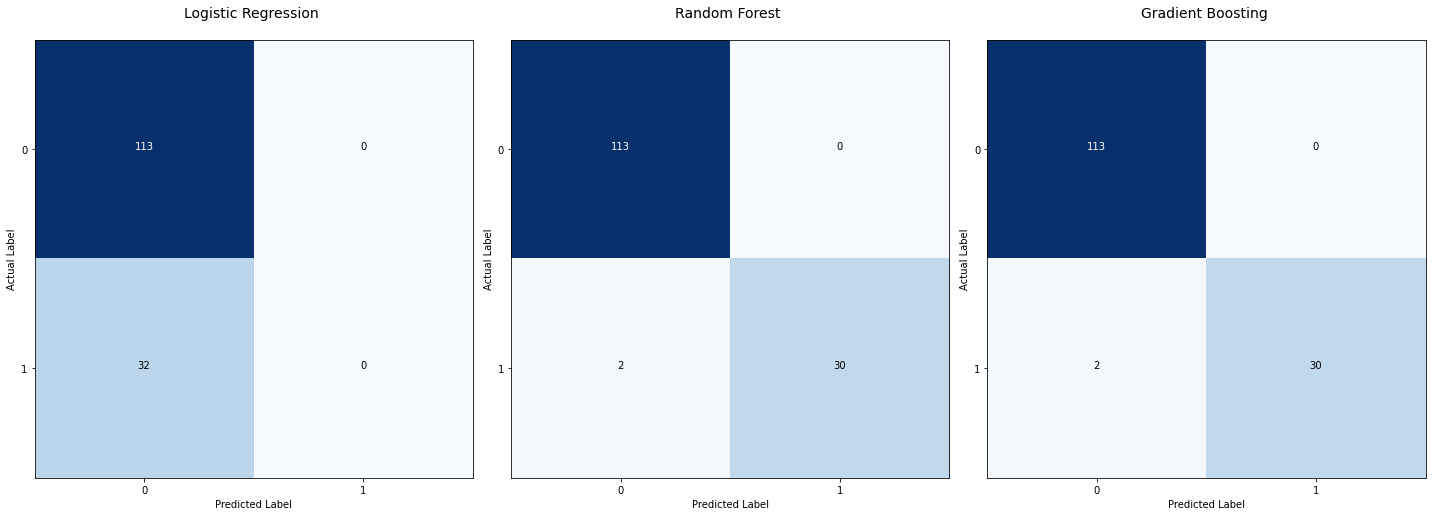

In [6]:
models = build_models(X_train, y_train, X_test, y_test)

## 3. Model Deployment

In [ ]:
# Specify a name for the space being created, the saved model and the model deployment
space_uid = ""
space_name = os.environ['space_name']
use_existing_space=True

model_to_deploy = models['Random Forest']
model_name = os.environ['model_name']
deployment_name = os.environ['deployment_name']

In [40]:
deployment_details = model_deploy(space_uid, space_name, use_existing_space, model_to_deploy, model_name,  deployment_name, X_train, y_train)

Deployment space with name Customer Attrition Space already exists . .
Using the existing space
Using the existing space


#######################################################################################

Synchronous deployment creation for uid: 'bf105503-bb1a-4f92-bdfe-e808a3f1c809' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.

ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='33257122-5aa4-4cb2-a566-76e3f9c432ae'
------------------------------------------------------------------------------------------------




## 4. Test the deployment endpoint

In [35]:
payload_scoring = {"input_data": [{"fields": X_train.columns.tolist(), "values": [X_train.iloc[0].values.tolist(), X_train.iloc[1].values.tolist()]}]}

In [37]:
import json
print(json.dumps(payload_scoring))

{"input_data": [{"fields": ["CUSTOMER_ANNUAL_INCOME", "NUM_ACCOUNTS_WITH_RISK_TOLERANCE_LOW", "CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS", "CUSTOMER_FAMILY_SIZE", "CUSTOMER_INTERNET_BANKING_INDICATOR", "CUSTOMER_NUMBER_OF_DEPENDENT_CHILDREN", "NUM_ACCOUNTS_WITH_RISK_TOLERANCE_VERY_LOW", "CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT", "CUSTOMER_SUMMARY_AVERAGE_SENTIMENT_SCORE", "NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_INCOME", "NUM_ACCOUNTS_WITH_RISK_TOLERANCE_MODERATE", "NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_GROWTH", "NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURE_GROWTH", "CUSTOMER_SUMMARY_NUMBER_OF_ACCOUNTS", "NUM_ACCOUNTS_WITH_RISK_TOLERANCE_HIGH", "CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_mean", "CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_std", "CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_min", "CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_max", "CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT_mean", "CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT_min", "CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT_max", "CUSTOM